# Implementing an Image Classification Application

`Linux` `Windows` `Ascend` `GPU` `CPU` `Whole Process` `Beginner` `Intermediate` `Expert`

[![](https://gitee.com/mindspore/docs/raw/r1.3/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/r1.3/docs/mindspore/programming_guide/source_en/quick_start/quick_start.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/r1.3/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r1.3/programming_guide/en/mindspore_quick_start.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/r1.3/resource/_static/logo_modelarts.png)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9taW5kc3BvcmUtd2Vic2l0ZS5vYnMuY24tbm9ydGgtNC5teWh1YXdlaWNsb3VkLmNvbS9ub3RlYm9vay9yMS4zL3Byb2dyYW1taW5nX2d1aWRlL2VuL21pbmRzcG9yZV9xdWlja19zdGFydC5pcHluYg==&imageid=65f636a0-56cf-49df-b941-7d2a07ba8c8c)

## Overview

This document uses a practice example to demonstrate the basic functions of MindSpore. For common users, it takes 20 to 30 minutes to complete the practice.

During the practice, a simple image classification function is implemented. The overall process is as follows:

1. Process the required dataset. The MNIST dataset is used in this example.
2. Define a network. The LeNet network is used in this example.
3. The loss value and precision value of the model collected by the custom callback function.
4. Define the loss function and optimizer.
5. Load the dataset and perform training. After the training is complete, check the result and save the model file.
6. Load the saved model for inference.
7. Validate the model, load the test dataset and trained model, and validate the result accuracy.

This is a simple and basic application process. Other advanced and complex applications can be extended based on this basic process.

> This document is applicable to CPU, GPU and Ascend environments.
>
> You can find the complete executable sample code at <https://gitee.com/mindspore/docs/tree/r1.3/docs/sample_code/lenet>.

## Preparations

Before you start, check whether MindSpore has been correctly installed. If not, install MindSpore on your computer by visiting [MindSpore installation page](https://www.mindspore.cn/install/en).  

In addition, you shall have basic mathematical knowledge such as Python coding basics, probability, and matrix.

Start your MindSpore experience now.

### Downloading the Dataset

The `MNIST` dataset used in this example consists of 10 classes of 28 x 28 pixels grayscale images. It has a training set of 60,000 examples, and a test set of 10,000 examples.

Execute the following command in jupyter notebook to download the MNIST dataset.

> Download the MNIST dataset at <http://yann.lecun.com/exdb/mnist/>. This page provides four download links of dataset files. The first two links are required for data training, and the last two links are required for data test.

In [1]:
!mkdir -p ./datasets/MNIST_Data/train ./datasets/MNIST_Data/test
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte --no-check-certificate
!tree ./datasets/MNIST_Data

./datasets/MNIST_Data
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte

2 directories, 4 files


### Importing Python Libraries and Modules

Before start, you need to import Python libraries.

Currently, only the `os` library is required. Other libraries are not described here.

In [2]:
import os

For details about MindSpore modules, search on the [MindSpore API Page](https://www.mindspore.cn/docs/api/en/r1.3/index.html).

### Configuring the Running Information

Before compiling code, you need to learn basic information about the hardware and backend required for MindSpore running.

You can use `context.set_context` to configure the information required for running, such as the running mode, backend information, and hardware information.

Import the `context` module and configure the required information.

In [3]:
from mindspore import context

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

This example runs in graph mode. You can configure hardware information based on actual requirements. For example, if the code runs on the Ascend AI processor, set `--device_target` to `Ascend`. This rule also applies to the code running on the CPU and GPU. For details about parameters, see the API description for `context.set_context`.

## Processing Data

Datasets are important for training. A good dataset can effectively improve training accuracy and efficiency. Generally, before loading a dataset, you need to perform some operations on the dataset.

A convolutional neural network such as LeNet is used to train the dataset. During data training, the data format is required. Therefore, you need to check the data in the dataset first. In this way, a targeted data conversion function can be constructed to convert the data in the dataset into a data format that meets the training requirements.

Execute the following code to view the original dataset data:

The type of mnist_ds: <class 'mindspore.dataset.engine.datasets.MnistDataset'>
Number of pictures contained in the mnist_ds： 60000
The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (28, 28, 1)
The label of item: 9


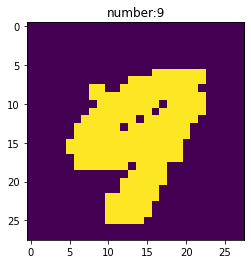

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import mindspore.dataset as ds

train_data_path = "./datasets/MNIST_Data/train"
test_data_path = "./datasets/MNIST_Data/test"
mnist_ds = ds.MnistDataset(train_data_path)
print('The type of mnist_ds:', type(mnist_ds))
print("Number of pictures contained in the mnist_ds：", mnist_ds.get_dataset_size())

dic_ds = mnist_ds.create_dict_iterator()
item = next(dic_ds)
img = item["image"].asnumpy()
label = item["label"].asnumpy()

print("The item of mnist_ds:", item.keys())
print("Tensor of image in item:", img.shape)
print("The label of item:", label)

plt.imshow(np.squeeze(img))
plt.title("number:%s"% item["label"].asnumpy())
plt.show()

From the above operation, we can see that the training datasets `train-images-idx3-ubyte` and `train-labels-idx1-ubyte` correspond to 60,000 images and 60,000 digital labels. After loading the data, the dictionary data set is converted by `create_dict_iterator`. View one of the data, which is a dictionary with keys `image` and `label`. The tensor of `image` (height: 28; width: 28; channel: 1) and `label` are numbers corresponding to the image.

### Defining the Dataset and Data Operations

Define the `create_dataset` function to create a dataset. In this function, define the data augmentation and processing operations to be performed.

1. Define the dataset.
2. Define parameters required for data augmentation and processing.
3. Generate corresponding data augmentation operations according to the parameters.
4. Use the `map` mapping function to apply data operations to the dataset.
5. Process the generated dataset.

After the definition is completed, use `create_datasets` to perform data augmentation on the original data, and extract a `batch` of data to view the changes after data augmentation.

In [5]:
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """
    create dataset for train or test

    Args:
        data_path (str): Data path
        batch_size (int): The number of data records in each group
        repeat_size (int): The number of replicated data records
        num_parallel_workers (int): The number of parallel workers
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # according to the parameters, generate the corresponding data enhancement method
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # using map to apply operations to a dataset
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    # process the generated dataset
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

ms_dataset = create_dataset(train_data_path)
print('Number of groups in the dataset:', ms_dataset.get_dataset_size())

Number of groups in the dataset: 1875


After the data augmentation function is called, the dataset `size` changes from 60000 to 1875, which meets the expectations of the `mnist_ds.batch` operation in data augmentation ($60000/32=1875$).

In the preceding augmentation process:

- The `label` data enhancement operation in the dataset:

    - `C.TypeCast`: Convert the data type to `int32`.

- The `image` data enhancement operation in the dataset:  

    - `datasets.MnistDataset`: Convert the dataset into MindSpore trainable data.  
    - `CV.Resize`: Resize image data pixels to meet the data size requirements of the LeNet network.
    - `CV.Rescale`: Standardize and normalize image data so that the value of each pixel is in the range (0,1), which can improve training efficiency.  
    - `CV.HWC2CHW`: Transform the image data tensor, the tensor form is changed from `height x width x channel` (HWC) to `channel x height x width` (CHW), which is convenient for data training.

- Other enhancement operations:

    - `mnist_ds.shuffle`: Randomly store data in a memory that can hold 10,000 images for shuffle.  
    - `mnist_ds.batch`: Extract 32 images from the shuffled 10,000 image addresses to form a `batch`, the parameter `batch_size` indicates the number of data contained in each group, and each group is now set to contain 32 data.  
    - `mnist_ds.repeat`: The `batch` data is replicated and enhanced. The parameter `repeat_size` indicates the number of replicated datasets.

Perform the `shuffle` and `batch` operations, and then perform the `repeat` operation to ensure that data is unique during one `epoch`.

> MindSpore supports multiple data processing and augmentation operations, which are usually used in combined. For details, see section [Data Processing](https://www.mindspore.cn/docs/programming_guide/en/r1.3/dataset_sample.html) and [Data Augmentation](https://www.mindspore.cn/docs/programming_guide/en/r1.3/augmentation.html) in the MindSpore tutorials.

### Viewing Enhanced Data

Obtain a group of data from the 1875 groups of data and view the data tensor and `label`.

In [6]:
data = next(ms_dataset.create_dict_iterator(output_numpy=True))
images = data["image"]
labels = data["label"]
print('Tensor of image:', images.shape)
print('Labels:', labels)

Tensor of image: (32, 1, 32, 32)
Labels: [5 5 6 4 7 0 1 2 2 8 7 4 3 3 6 5 8 9 6 6 9 7 9 8 2 9 0 2 4 3 9 3]


Visualize the tensor data and the value corresponding to `label`.

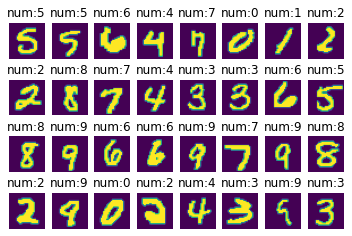

In [7]:
count = 1
for i in images:
    plt.subplot(4, 8, count)
    plt.imshow(np.squeeze(i))
    plt.title('num:%s'%labels[count-1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()

Through the above query operation, you can see the transformed images. The dataset is divided into 1875 groups of data. Each group of data contains 32 images. The resolution of each image is 32 x 32. After all the data is prepared, you can proceed to the next step of data training.

## Defining the Network

The LeNet network is relatively simple. In addition to the input layer, the LeNet network has seven layers, including two convolutional layers, two down-sample layers (pooling layers), and three full connection layers. Each layer contains different numbers of training parameters, as shown in the following figure:

> For details about the LeNet network, visit <http://yann.lecun.com/exdb/lenet/>.

You can initialize the full connection layers and convolutional layers by `Normal`.

MindSpore supports multiple parameter initialization methods, such as `TruncatedNormal`, `Normal`, and `Uniform`, default value is `Normal`. For details, see the description of the `mindspore.common.initializer` module in the MindSpore API.

To use MindSpore for neural network definition, inherit `mindspore.nn.Cell`. `Cell` is the base class of all neural networks (such as `Conv2d`).

Define each layer of a neural network in the `__init__` method in advance, and then define the `construct` method to complete the forward construction of the neural network. According to the structure of the LeNet network, define the network layers as follows:

In [8]:
import mindspore.nn as nn
from mindspore.common.initializer import Normal

class LeNet5(nn.Cell):
    """Lenet network structure."""
    # define the operator required
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.max_pool2d(self.relu(self.conv1(x)))
        x = self.max_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

network = LeNet5()
print("layer conv1:", network.conv1)
print("*"*40)
print("layer fc1:", network.fc1)

layer conv1: Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5),stride=(1, 1),  pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=Falseweight_init=normal, bias_init=zeros, format=NCHW>
****************************************
layer fc1: Dense<input_channels=400, output_channels=120, has_bias=True>


After the construction is completed, you can use `print(LeNet5())` to print out all the parameters of each layer in the neural network, or use `LeNet().{layer name}` to print the corresponding parameter information. This example chooses to print the corresponding parameters of the first convolutional layer and the first fully connected layer.

## Custom Callback Function to Collect the Model Loss Value and Precision Value

Customize a data collection callback class `StepLossAccInfo`, it is used to collect two types of information:

1. Information about the relationship between `step` and `loss` values during training;

2. Information of each 125 training `step` and corresponding model accuracy value `accuracy`.

This class inherits the `Callback` class. You can customize operations during training. After the training is completed, the data can be drawn into a graph to view the changes in `step` and `loss`, as well as the `step` and `accuracy` changes.

The following code will be used as a callback function to be called in the model training function `model.train`. The following visualizes the information collected during the model verification stage.

In [9]:
from mindspore.train.callback import Callback

# custom callback function
class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.steps_loss = steps_loss
        self.steps_eval = steps_eval

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        cur_step = (cur_epoch-1)*1875 + cb_params.cur_step_num
        self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
        self.steps_loss["step"].append(str(cur_step))
        if cur_step % 125 == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])

In the preceding information:

- `model`: computational graph model.
- `eval_dataset`: validation dataset.
- `steps_loss`: Collect the relationship between step and loss value, the data format is `{"step": [], "loss_value": []}`.
- `steps_eval`: Collect information about the model accuracy value `accuracy` corresponding to step, the data format is `{"step": [], "acc": []}`.

## Defining the Loss Function and Optimizer

Before definition, this section briefly describes concepts of loss function and optimizer.

- Loss function: It is also called objective function and is used to measure the difference between a predicted value and an actual value. Deep learning reduces the value of the loss function by continuous iteration. Defining a good loss function can effectively improve the model performance.

- Optimizer: It is used to minimize the loss function, improving the model during training.

After the loss function is defined, the weight-related gradient of the loss function can be obtained. The gradient is used to indicate the weight optimization direction for the optimizer, improving model performance.

Loss functions supported by MindSpore include `SoftmaxCrossEntropyWithLogits`, `L1Loss`, `MSELoss`. The loss function `SoftmaxCrossEntropyWithLogits` is used in this example.

The optimizers supported by MindSpore include `Adam`, `AdamWeightDecay`, `Momentum`, etc. The popular `Momentum` optimizer is used here.

In [10]:
import mindspore.nn as nn
from mindspore.nn import SoftmaxCrossEntropyWithLogits

lr = 0.01
momentum = 0.9

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

## Training the Network

After completing the construction of the neural network, you can start network training. The network training can be conveniently performed through the `Model.train` interface provided by MindSpore. The parameters mainly include:

1. `epoch_size`: specifies the number of batches of images that need to be traversed by each epoch.
2. `ds_train`: specifies the training dataset.
3. MindSpore-provided callback mechanism. The callback function `callbacks` contains `ModelCheckpoint`, `LossMonitor`, and `Callback` arguments, where `ModelCheckpoint` is used to save network models and parameters for performing fine-tuning.
4. `dataset_sink_mode`: specifies the dataset sink mode. The default value `True` needs to be  set to `False` because this mode does not support the CPU computing platform.

In [11]:
import os
from mindspore import Tensor, Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.nn import Accuracy

epoch_size = 1
mnist_path = "./datasets/MNIST_Data"
model_path = "./models/ckpt/mindspore_quick_start/"

repeat_size = 1
ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)
eval_dataset = create_dataset(os.path.join(mnist_path, "test"), 32)

# clean up old run files before in Linux
os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))

# define the model
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()} )

# save the network model and parameters for subsequence fine-tuning
config_ck = CheckpointConfig(save_checkpoint_steps=375, keep_checkpoint_max=16)
# group layers into an object with training and evaluation features
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", directory=model_path, config=config_ck)

steps_loss = {"step": [], "loss_value": []}
steps_eval = {"step": [], "acc": []}
# collect the steps,loss and accuracy information
step_loss_acc_info = StepLossAccInfo(model , eval_dataset, steps_loss, steps_eval)

model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(125), step_loss_acc_info], dataset_sink_mode=False)

epoch: 1 step: 125, loss is 0.13396409
epoch: 1 step: 250, loss is 0.1545082
epoch: 1 step: 375, loss is 0.12724978
epoch: 1 step: 500, loss is 0.034271903
epoch: 1 step: 625, loss is 0.13005787
epoch: 1 step: 750, loss is 0.010596659
epoch: 1 step: 875, loss is 0.008820764
epoch: 1 step: 1000, loss is 0.09243655
epoch: 1 step: 1125, loss is 0.054233808
epoch: 1 step: 1250, loss is 0.074425355
epoch: 1 step: 1375, loss is 0.005053058
epoch: 1 step: 1500, loss is 0.13170624
epoch: 1 step: 1625, loss is 0.028616104
epoch: 1 step: 1750, loss is 0.12095115
epoch: 1 step: 1875, loss is 0.013343395


After training, multiple model files will be generated and saved under the pre-set directory.

In [12]:
!tree $model_path

./models/ckpt/mindspore_quick_start/
├── checkpoint_lenet-1_1125.ckpt
├── checkpoint_lenet-1_1500.ckpt
├── checkpoint_lenet-1_1875.ckpt
├── checkpoint_lenet-1_375.ckpt
├── checkpoint_lenet-1_750.ckpt
└── checkpoint_lenet-graph.meta

0 directories, 6 files


The meaning of the file name: `{Customized name configured in ModelCheckpoint}-{The number of epoch}-{The number of step}`.

> To use free control loop iterations, traversing data sets, etc., you can refer to the "Customizing a Training Cycle" part of the official website programming guide "[Training](https://www.mindspore.cn/docs/programming_guide/en/r1.3/train.html#customizing-a-training-cycle)".

### Checking the Loss Value of the Model with the Change of Training Steps

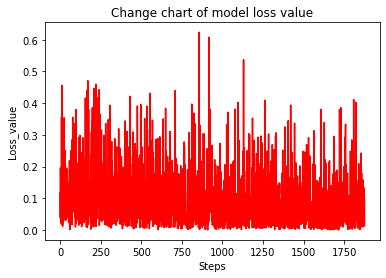

In [13]:
steps = steps_loss["step"]
loss_value = steps_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Change chart of model loss value")
plt.show()

Judging from the above, it can be divided into three stages:

Stage 1: When the training starts, the loss value is around 2.2, which indicates that the training performance is not satisfied.

Stage 2: When the training arrives at a certain point, the loss value decreases sharply and the training performance is greatly improved.

Stage 3: After the loss value converges to a small value, it tends to get close to 0. At this point, the training performance is steady and cannot be further improved, leading to the result that the training is terminated.

## Validating the Model

After obtaining the model file, validate the model generalization capability.

The process of building a network for verification is as follows:

1. Load the model by reading the parameter `param_dict` in the `.ckpt` file.
2. Load the parameter `param_dict` to the neural network, Lenet.
3. Load the test dataset.
4. Call the function, `model.eval`, to transfer the parameters of the test dataset, `ds_eval`. Compute the accuracy of `checkpoint_lenet-{epoch}_1875.ckpt`

In [14]:
from mindspore import load_checkpoint, load_param_into_net

# testing relate modules
def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("./models/ckpt/mindspore_quick_start/checkpoint_lenet-1_1875.ckpt")
    # load parameter to the network
    load_param_into_net(network, param_dict)
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=False)
    print("============== Accuracy:{} ==============".format(acc))

test_net(network, model, mnist_path)

============== Starting Testing ==============
============== Accuracy:{'Accuracy': 0.9758613782051282} ==============


In the preceding information:

- `load_checkpoint`：This API is used to load the CheckPoint model parameter file and return a parameter dictionary.

- `checkpoint_lenet-1_1875.ckpt`：name of the saved CheckPoint model file.

- `load_param_into_net`：This API is used to load parameters to the network.

When the training step reaches 1875, the accuracy of the model is over 95%, meaning the model performance is good.

We can check the change of the model accuracy as the training step changes.

`eval_show` draws the line chart of model accuracy every 25 `step`. In particular, `steps_eval` stores the training step of the model and the corresponding accuracy information.

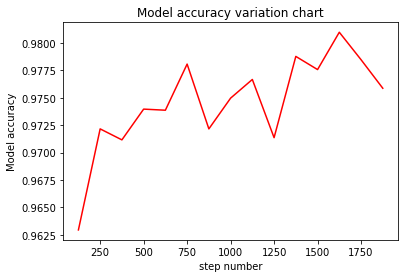

In [15]:
def eval_show(steps_eval):
    plt.xlabel("step number")
    plt.ylabel("Model accuracy")
    plt.title("Model accuracy variation chart")
    plt.plot(steps_eval["step"], steps_eval["acc"], "red")
    plt.show()

eval_show(steps_eval)

In the figure, it can be seen that the change of the model accuracy can be divided in three stages:

Stage 1: When the training starts, the model accuracy rises slowly.

Stage 2: At a certain point, the model accuracy rises sharply.

Stage 3: The model accuracy nearly comes to 1 without reaching.

During the training process, as the training data increases, it will have a positive correlation with the model accuracy, but as the accuracy reaches a certain level, the training gains will decrease.

## Inference and Prediction

Apply the trained model to predict a single image or a set of images. The procedure is as follows:

1. Transform the test data to the data that fits LeNet.
2. Extract the `image` data.
3. Call the function, `model.predict`, to predict the corresponding digit in each `image`. To be noted, `predict` will returns the probability of predicting 0 to 9 for each `image`.
4. Call the `plot_pie` function to display the probability of predictions. Negative probabilities will be removed and not be displayed.

Load the dataset to be predicted and call the `create_dataset` function to transform the test dataset into required formats. Select a set of 32 images for inference and prediction.

Row 1, column 7 is incorrectly identified as 5, the correct value should be 3 

[2 0 1 3 0 0 5 8 7 2 6 2 7 3 1 2 9 5 4 6 0 3 0 8 3 9 5 1 9 6 4 2] <--Predicted figures
[2 0 1 3 0 0 3 8 7 2 6 2 7 3 1 2 9 5 4 6 0 3 0 8 3 9 5 1 9 6 4 2] <--The right number


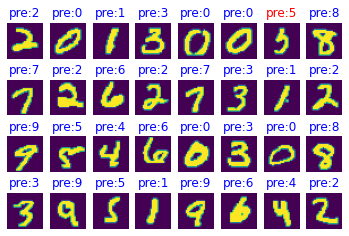

In [16]:
ds_test = create_dataset(test_data_path).create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

output = model.predict(Tensor(data['image']))
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i+1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i/8)+1, i%8+1, pred[i], labels[i]), '\n')
if index:
    print("All the figures in this group are predicted correctly!")
print(pred, "<--Predicted figures")
print(labels, "<--The right number")
plt.show()

Draw a pie chart for probability analysis. In this example, it displays a pie chart for the current `batch` in the first image.

`prb` stores the preceding 32 prediction numbers and corresponding output results. The classification result `prb[0]` corresponding to the first image is obtained, and the sigmol formula $\frac{1}{1+e^{-x}}$ is used to obtain the probability of [0-9] corresponding to the image. The number whose probability value is greater than 0.5 is analyzed in the pie chart.

The probability of corresponding numbers [0-9] in Figure 1:
 [0.054608213813288335, 0.04007988333681419, 0.9999934046689553, 0.9469836696068331, 0.347608619405929, 0.020873059274634436, 0.0013652782671098932, 0.9990516692085604, 0.39083703602997244, 0.036189847324771866]


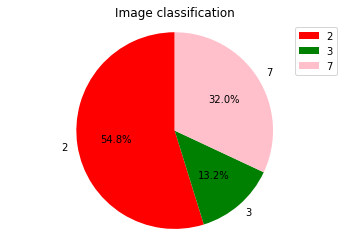

In [17]:
import numpy as np
# define the pie drawing function of probability analysis

prb = output.asnumpy()

def plot_pie(prbs):
    dict1 = {}
    # remove the negative number and build the dictionary dict1. The key is the number and the value is the probability value
    for i in range(10):
        if prbs[i] > 0:
            dict1[str(i)] = prbs[i]

    label_list = dict1.keys()
    size = dict1.values()
    colors = ["red", "green", "pink", "blue", "purple", "orange", "gray"]
    color = colors[: len(size)]
    plt.pie(size, colors=color, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
    plt.axis("equal")
    plt.legend()
    plt.title("Image classification")
    plt.show()


print("The probability of corresponding numbers [0-9] in Figure 1:\n", list(map(lambda x:1/(1+np.exp(-x)), prb[0])))
plot_pie(prb[0])

That's the whole experience of the handwritten number classification application.